# Pump it Up: Data Mining the Water Table

### Can you predict which water pumps are faulty?
Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

Competition:
https://www.drivendata.org/competitions/7/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys

import numpy as np
import pandas as pd

import sklearn as sk
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
TRAIN_PATH = 'data/train_clean.csv'
TEST_PATH = 'data/test_clean.csv'

train_df = pd.read_csv(TRAIN_PATH,
                       index_col='id')
test_df = pd.read_csv(TEST_PATH,
                      index_col='id')

In [3]:
train_labels = train_df.pop('status_group').copy()
train_data = train_df.copy()
test_data = test_df.copy()

In [4]:
def print_shapes():
    print('train_data shape: {}'.format(train_data.shape))
    print('train_labels shape: {}'.format(train_labels.shape))
    print('test_data shape: {}'.format(test_data.shape))

print_shapes()

train_data shape: (59400, 15)
train_labels shape: (59400,)
test_data shape: (14850, 15)


## Normalization of numerical attributes
Also possible to do this after 1-hot-encoding of categorical features.

In [5]:
# all numeric columns to float
def int_columns_to_float(df: pd.DataFrame):
    for cname in df.columns:
        if df[cname].dtype == int:
            df[cname] = df[cname].astype(float)

int_columns_to_float(train_data)
int_columns_to_float(test_data)

In [6]:
def numeric_columns(df: pd.DataFrame):
    cols = []
    for cname in df.columns:
        if df[cname].dtype != object:
            cols.append(cname)
    return cols
    
numeric_cols = numeric_columns(train_data)

scaler = StandardScaler()
scaler.fit(train_data[numeric_cols])
train_data[numeric_cols] = scaler.transform(train_data[numeric_cols])
test_data[numeric_cols] = scaler.transform(test_data[numeric_cols])

## Encode categorical attributes
- LabelEncoder (ordered)
- LabelBinarizer / get_dummies (unordered)

In [7]:
train_data = pd.get_dummies(train_data)
train_data.columns.size

158

In [8]:
test_data = pd.get_dummies(test_data)
test_data.columns.size

158

In [9]:
print_shapes()

train_data shape: (59400, 158)
train_labels shape: (59400,)
test_data shape: (14850, 158)


In [10]:
train_labels = train_labels.as_matrix()
train_data = train_data.as_matrix()
test_data = test_data.as_matrix()

## Model selection

In [11]:
LR = 0.001
WD = 5e-6
DROP_RATE = 0.25

In [12]:
tf.reset_default_graph()

# set random seed after resetting the graph
tf.set_random_seed(42)
np.random.seed(4422)

In [13]:
global_step = tf.train.create_global_step()

x_ph = tf.placeholder(tf.float32, shape=[None, train_data.shape[-1]])
y_ph = tf.placeholder(tf.int64, shape=[None])
is_training_ph = tf.placeholder_with_default(False, shape=[])

def inference(x, is_training):
    z = tf.layers.dense(x,100,
                        activation=tf.nn.elu,
                        kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(WD))
    #z = tf.layers.batch_normalization(z, training=is_training)
    z = tf.layers.dense(z, 100,
                        activation=tf.nn.elu,
                        kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(WD))
    #z = tf.layers.batch_normalization(z, training=is_training)
    z = tf.layers.dense(z, 100,
                        activation=tf.nn.elu,
                        kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(WD))
    z = tf.layers.dropout(z, rate=DROP_RATE, training=is_training)
    logits = tf.layers.dense(z, 3,
                             kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(WD))
    return logits

logits = inference(x_ph, is_training_ph)

In [14]:
labels_one_hot = tf.one_hot(y_ph, depth=3)
cost_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_one_hot, logits=logits))

wd_costs = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
if len(wd_costs) > 0:
    total_cost_op = cost_op + tf.add_n(wd_costs, 'wd_costs')
else:
    total_cost_op = cost_op

train_op = tf.train.AdamOptimizer(LR).minimize(total_cost_op, global_step=global_step)

In [24]:
prediction_op = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction_op, tf.cast(y_ph, dtype=tf.int64))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training

In [16]:
sess = tf.InteractiveSession()

In [17]:
tf.global_variables_initializer().run()

#### Simple train/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=None)

In [20]:
def shuffle_together(data, targets):
    perm = np.random.permutation(data.shape[0])
    return data[perm], targets[perm]

In [ ]:
num_epochs = 50
batch_size = 200
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch + 1))
    # shuffle data
    X_train, y_train = shuffle_together(X_train, y_train)
    
    batches_per_epoch = int(X_train.shape[0] / batch_size)
    for step in range(batches_per_epoch):
        batch_x = X_train[step*batch_size:(step+1)*batch_size]
        batch_y = y_train[step*batch_size:(step+1)*batch_size]
        feed = {
            x_ph: batch_x,
            y_ph: batch_y,
            is_training_ph: True
        }
        _, cost = sess.run([train_op, cost_op], feed_dict=feed)
        
        if step % 100 == 0:
            print('@{:<3}: {:.4f}'.format(step, cost))
            
    # validation
    cost, accuracy = sess.run([cost_op, accuracy_op], feed_dict= {
        x_ph: X_test,
        y_ph: y_test
    })
    print('>>> Validation: cost: {:.4f}, accuracy: {:.3f}%'.format(cost, accuracy * 100))
    cost, accuracy = sess.run([cost_op, accuracy_op], feed_dict= {
        x_ph: X_train,
        y_ph: y_train
    })
    print('>>> Val@train: cost: {:.4f}, accuracy: {:.3f}%'.format(cost, accuracy * 100))        

## Train for submission

In [21]:
X_train, y_train = (train_data, train_labels)

In [23]:
num_epochs = 100
batch_size = 200
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch + 1))
    # shuffle data
    X_train, y_train = shuffle_together(X_train, y_train)
    
    batches_per_epoch = int(X_train.shape[0] / batch_size)
    for step in range(batches_per_epoch):
        batch_x = X_train[step*batch_size:(step+1)*batch_size]
        batch_y = y_train[step*batch_size:(step+1)*batch_size]
        feed = {
            x_ph: batch_x,
            y_ph: batch_y,
            is_training_ph: True
        }
        _, cost = sess.run([train_op, cost_op], feed_dict=feed)
        
        if step % 100 == 0:
            print('@{:<3}: {:.4f}'.format(step, cost))
            
    # train scores
    cost, accuracy = sess.run([cost_op, accuracy_op], feed_dict= {
        x_ph: X_train,
        y_ph: y_train
    })
    print('>>> Val@train: cost: {:.4f}, accuracy: {:.3f}%'.format(cost, accuracy * 100)) 

Starting epoch 1...
@0  : 0.4463
@100: 0.4667
@200: 0.4313
>>> Val@train: cost: 0.4608, accuracy: 81.024%
Starting epoch 2...
@0  : 0.4914
@100: 0.4687
@200: 0.4972
>>> Val@train: cost: 0.4620, accuracy: 80.891%
Starting epoch 3...
@0  : 0.4962
@100: 0.3761
@200: 0.5546
>>> Val@train: cost: 0.4625, accuracy: 80.941%
Starting epoch 4...
@0  : 0.4143
@100: 0.5706
@200: 0.4742
>>> Val@train: cost: 0.4591, accuracy: 81.064%
Starting epoch 5...
@0  : 0.4051
@100: 0.5384
@200: 0.4989
>>> Val@train: cost: 0.4623, accuracy: 80.939%
Starting epoch 6...
@0  : 0.4222
@100: 0.5128
@200: 0.4770
>>> Val@train: cost: 0.4618, accuracy: 80.904%
Starting epoch 7...
@0  : 0.5764
@100: 0.4466
@200: 0.4682
>>> Val@train: cost: 0.4558, accuracy: 81.120%
Starting epoch 8...
@0  : 0.5298
@100: 0.4095
@200: 0.4270
>>> Val@train: cost: 0.4554, accuracy: 81.157%
Starting epoch 9...
@0  : 0.4403
@100: 0.5151
@200: 0.4528
>>> Val@train: cost: 0.4552, accuracy: 81.273%
Starting epoch 10...
@0  : 0.4866
@100: 0.4505

## Predictions for submission

(array([4792.,    0.,    0.,    0.,    0.,  425.,    0.,    0.,    0.,
        9633.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

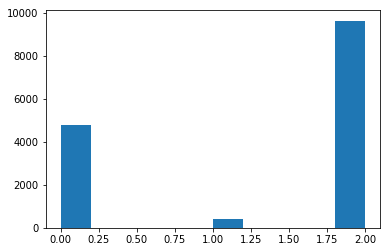

In [25]:
prediction = sess.run(prediction_op, feed_dict= {
        x_ph: test_data,
    })
plt.hist(prediction)

In [26]:
def save_submission(predictions, test):
    data = {'id': test.index, 'status_group': predictions}

    submit = pd.DataFrame(data=data)

    vals_to_replace = {0:'non functional',
                       1:'functional needs repair',
                       2:'functional'}

    submit['status_group'] = submit['status_group'].replace(vals_to_replace)        

    submit.to_csv('pump_predictions.csv', index=False)
    
save_submission(prediction, test_df)